In [1]:
import pandas as pd
import h5py
from dataload import dense_Dataset
import numpy as np
from utils import CNN, CNN_Dataloader, load_model
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
%load_ext autoreload
%autoreload 2

In [2]:
dataset = dense_Dataset('data/trizod_embeddings_pdb.h5', 'data/rest_set_dense.tsv', val_perc=0) 

In [3]:
print(len(dataset.test_keys))

2417


In [4]:
hparams = {
    'epochs': 30,
    'lr':0.001,
    'patience': 5,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}
model = load_model('models/cnn_model_0.001lr_30epochs_scheduler.pth', hparams)

In [5]:
test_loader = CNN_Dataloader(dataset, dataset.test_keys, batch_size=128, shuffle=True)

In [6]:
# test the model on the validation set
predictions = []
ground_truths = []
keys = []
model.eval()
for inputs, targets, ids in test_loader:
    inputs, targets = inputs.to(hparams['device']), targets.to(hparams['device'])
    outputs = model(inputs)
    predictions.append(outputs.detach().cpu().numpy())
    ground_truths.append(targets.cpu().numpy())
    keys.append(ids)


D:\programming\PP1\dataload.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.tensor(self.embed_file[index], dtype=torch.float), torch.tensor(self.dense[index],


In [7]:
print(predictions[0].shape)
print(ground_truths[0].shape)
print(len(keys[0]))

(128, 201)
(128, 201)
128


In [8]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()
# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")
protein_num = 4
protein_name = keys[-1][protein_num]
# pdbchain 4A8XA has 88 residues
truths = truths[protein_num][:88]
preds = preds[protein_num][:88]
mins = [min(truths[i], preds[i]) for i in range(len(truths))]
maxs = [max(truths[i], preds[i]) for i in range(len(truths))]
# choose line color to be blue if the prediction is less than the truth, else choose red
line_color = ['#5783A2' if preds[i] < truths[i] else 'tomato' for i in range(len(truths))]

MSE: 0.0004404381907079369


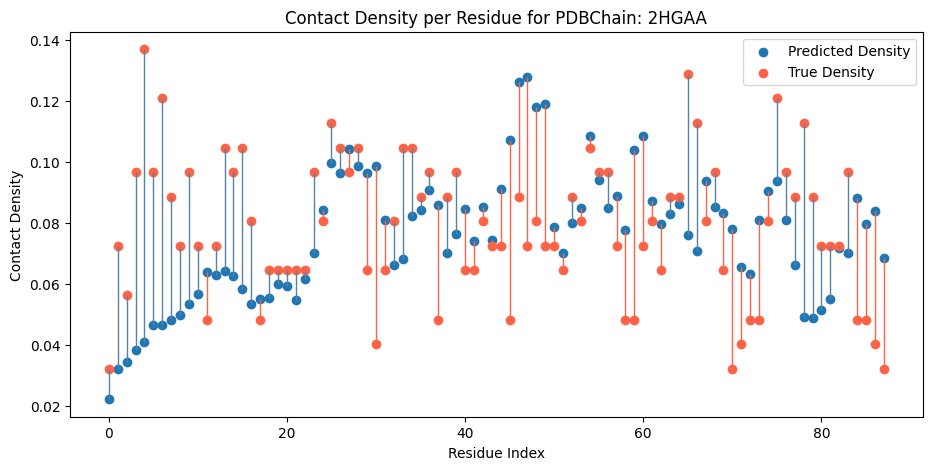

In [9]:
plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, label="Predicted Density")
plt.scatter(range(len(truths)), truths, c="tomato", label="True Density")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=mins, ymax=maxs, colors=line_color)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue for PDBChain: " + protein_name)
plt.legend()
# plt.savefig("cnn_test.png")
plt.show()

In [10]:
import pickle
predictions = {'test_preds': predictions, 'test_truths': ground_truths, 'test_ids': keys}
with open('trizod_rest_set_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)